## Carregar o dataset e as libs necessárias

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings("ignore")

In [219]:
data = pd.read_csv('sao-paulo-properties-april-2019.csv')

In [220]:
data.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436


## AED do dataset

In [221]:
data['Negotiation Type'].value_counts()

Negotiation Type
rent    7228
sale    6412
Name: count, dtype: int64

### Filtrar apenas para o tipo de negociacao "sale" - imóveis a venda

In [222]:
df = data[data['Negotiation Type'] == 'sale']
df_rent = data[data['Negotiation Type'] == 'rent']

In [223]:
df.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
4901,732600,1000,74,1,2,1,2,1,0,1,0,Vila Madalena/São Paulo,sale,apartment,-23.552129,-46.692244
4902,1990000,2400,164,4,5,2,3,1,1,1,0,Vila Madalena/São Paulo,sale,apartment,-23.551613,-46.699106
4903,720000,700,70,2,2,1,1,1,0,1,1,Vila Madalena/São Paulo,sale,apartment,-23.547687,-46.692594
4904,1680000,1580,155,3,5,3,2,1,0,1,0,Vila Madalena/São Paulo,sale,apartment,-23.552590,-46.691104
4905,1200000,900,56,2,2,1,2,0,1,1,0,Vila Madalena/São Paulo,sale,apartment,-23.553087,-46.697890


In [224]:
df_rent.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436


### Verificar a proporção dos imóveis a venda

In [225]:
percent_builds_sale = len(df)/len(data)
print(f'Os imoveis que estão disponiveis para comprar representa certa de {percent_builds_sale*100:.2f}% da base de dados.')

Os imoveis que estão disponiveis para comprar representa certa de 47.01% da base de dados.


### Analisar mais informações sobre as variáveis disponíveis

In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6412 entries, 4901 to 13639
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             6412 non-null   int64  
 1   Condo             6412 non-null   int64  
 2   Size              6412 non-null   int64  
 3   Rooms             6412 non-null   int64  
 4   Toilets           6412 non-null   int64  
 5   Suites            6412 non-null   int64  
 6   Parking           6412 non-null   int64  
 7   Elevator          6412 non-null   int64  
 8   Furnished         6412 non-null   int64  
 9   Swimming Pool     6412 non-null   int64  
 10  New               6412 non-null   int64  
 11  District          6412 non-null   object 
 12  Negotiation Type  6412 non-null   object 
 13  Property Type     6412 non-null   object 
 14  Latitude          6412 non-null   float64
 15  Longitude         6412 non-null   float64
dtypes: float64(2), int64(11), object(3)
memory 

### Analisar as estatísticas das variáveis
- Média
- Desvio padrão
- Quartis, entre outros

Tudo isso ajuda no entendimento dos dados que temos disponíveis para construir a rede neural e ajudar na previsão do modelo.

In [227]:
df.describe()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Latitude,Longitude
count,6.412000e+03,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000
mean,6.086241e+05,537.349813,78.611042,2.320805,2.037742,0.931535,1.326575,0.415471,0.117280,0.539457,0.032283,-22.127513,-43.705547
std,7.404515e+05,624.632473,50.872359,0.714743,0.917844,0.772615,0.751658,0.492841,0.321779,0.498480,0.176765,5.756660,11.271783
min,4.200000e+04,0.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-46.734483,-49.337815
25%,2.500000e+05,150.000000,50.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-23.592848,-46.673526
50%,3.800000e+05,400.000000,62.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,-23.549693,-46.628506
75%,6.790000e+05,700.000000,87.000000,3.000000,2.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,-23.512534,-46.533612
max,1.000000e+07,8920.000000,620.000000,6.000000,7.000000,6.000000,7.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000


#### Preço médio dos imóveis a venda e para alugar

In [228]:
# média dos preços dos imóveis
media_dos_imoveis = round(float(df.describe()['Price']['mean']), 2)
media_dos_imoveis_rent = round(float(df_rent.describe()['Price']['mean']), 2)

print(f"Média dos preços dos imóveis para venda: {media_dos_imoveis}")
print(f"Média dos preços dos imóveis para alugar: {media_dos_imoveis_rent}")

Média dos preços dos imóveis para venda: 608624.14
Média dos preços dos imóveis para alugar: 3077.67


#### Analisar as distribuições de forma geral das variáveis

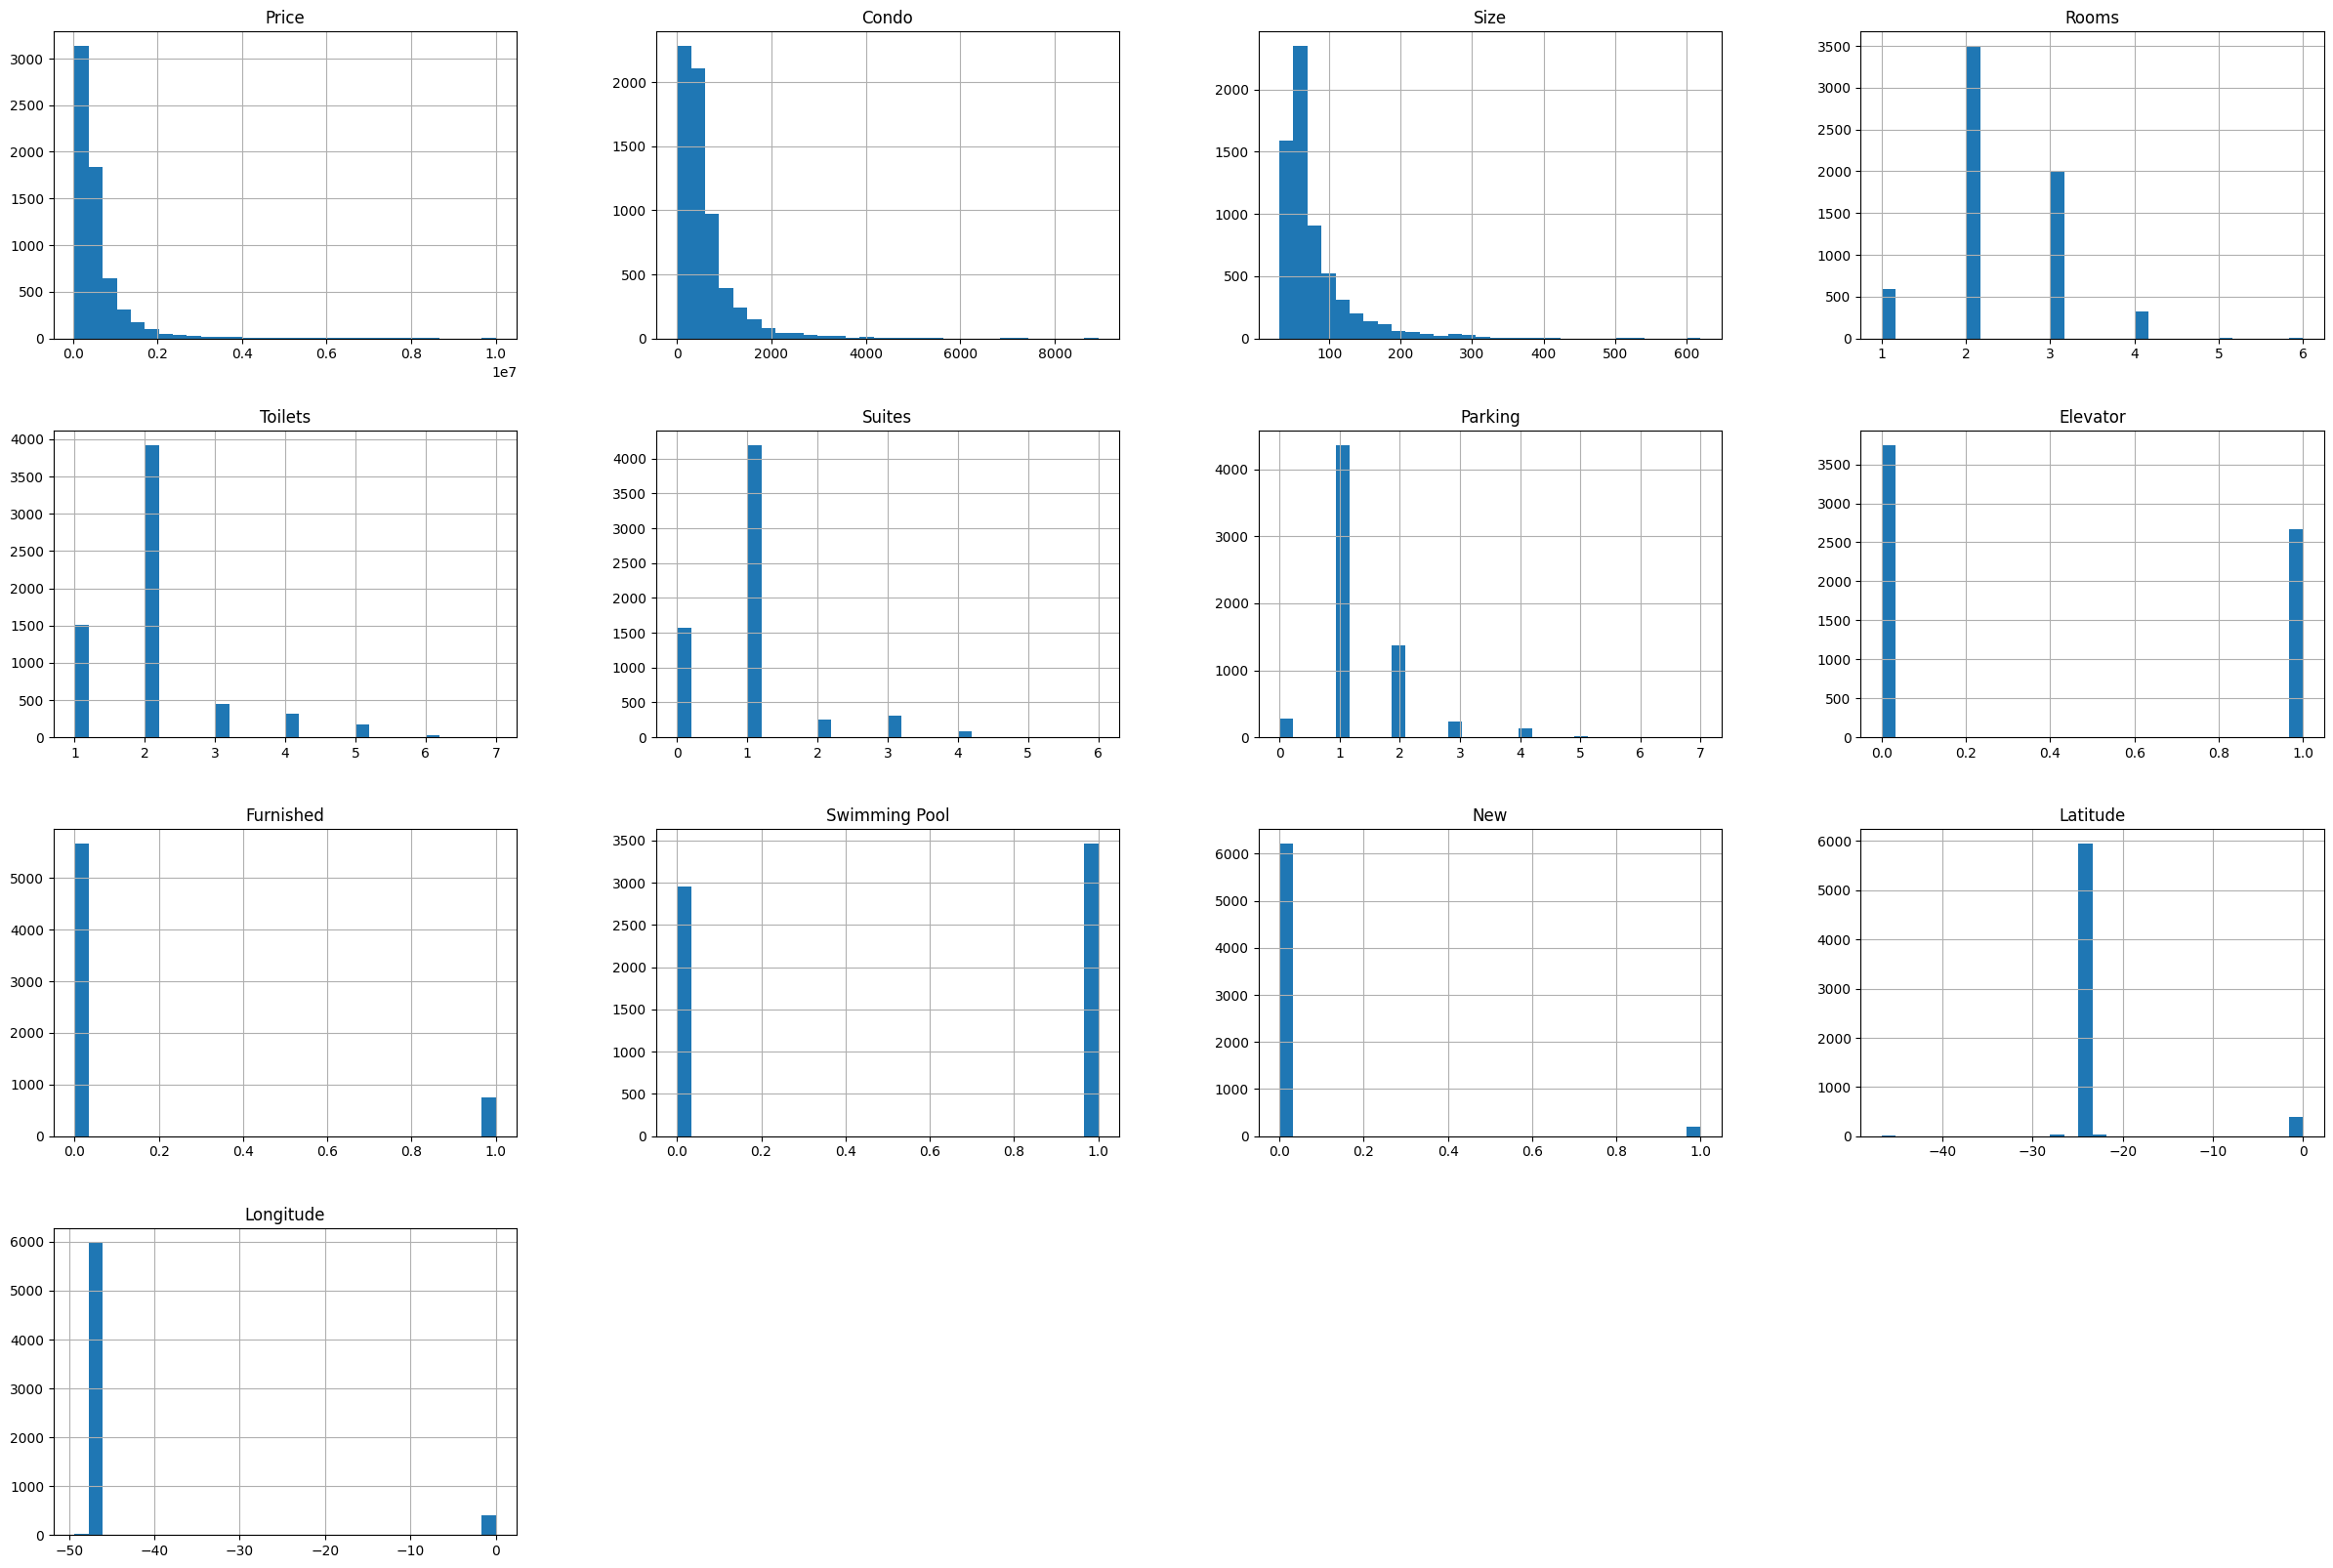

In [229]:
df.hist(bins=30, figsize=(30,20))
plt.show()

#### Os preços mais comuns dos imóveis - Top 5

In [230]:
df['Price'].value_counts().head()

Price
250000    97
240000    94
350000    93
320000    80
280000    80
Name: count, dtype: int64

#### Preço médio dos preços mais comuns dos imóveis - Top 5

In [231]:
# media de preco do top5 imoveis
float(df['Price'].value_counts().reset_index().head()['Price'].mean())

288000.0

A média de preço do top 5 imovéis dentro do conjunto de dados é de R$ 288.000,00

#### Verificar a distribuição dos preços dos imóveis a venda

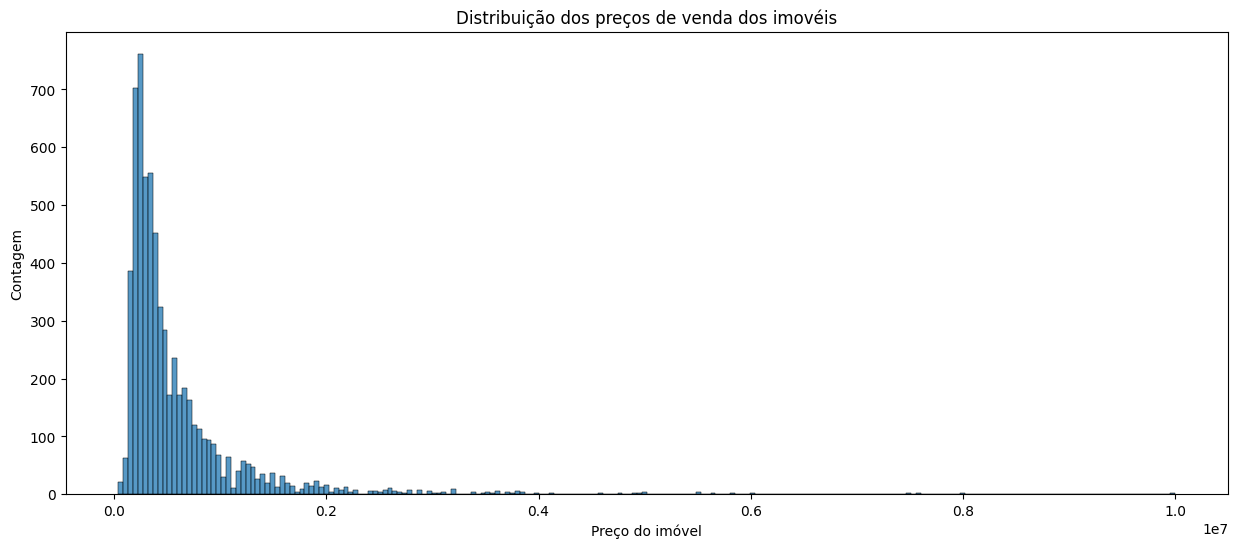

In [232]:
plt.figure(figsize=(15,6))
sns.histplot(df['Price'])
plt.title('Distribuição dos preços de venda dos imovéis')
plt.xlabel('Preço do imóvel')
plt.ylabel('Contagem')
plt.show()

#### Verificar quantos imóveis exitem abaixo do preço médio geral

In [233]:
# quantidade de imoveis abaixo da media geral de preço
quantidade_imoveis_abaixo_avg = len(df.loc[df['Price'] <= media_dos_imoveis]['Price'])
print('Quantidade de imóvesi abaixo da média geral de preço:', quantidade_imoveis_abaixo_avg)

Quantidade de imóvesi abaixo da média geral de preço: 4551


#### Verificar a proporção dos imóveis que estão abaixo do preço médio geral

In [234]:
# verificando a proporção da quantidade de imóveis abaixo a da média geral
proporcao_imoveis_abaixo_avg = round((quantidade_imoveis_abaixo_avg / df.shape[0])*100, 2)
print(f'Proporção da quantidade de imóveis abaixo da média geral: {proporcao_imoveis_abaixo_avg}%')

Proporção da quantidade de imóveis abaixo da média geral: 70.98%


> Cerca de 71% dos imóveis disponíveis para a venda estão abaixo da média geral. Enfatizando a distribuição dos preços no histograma acima.

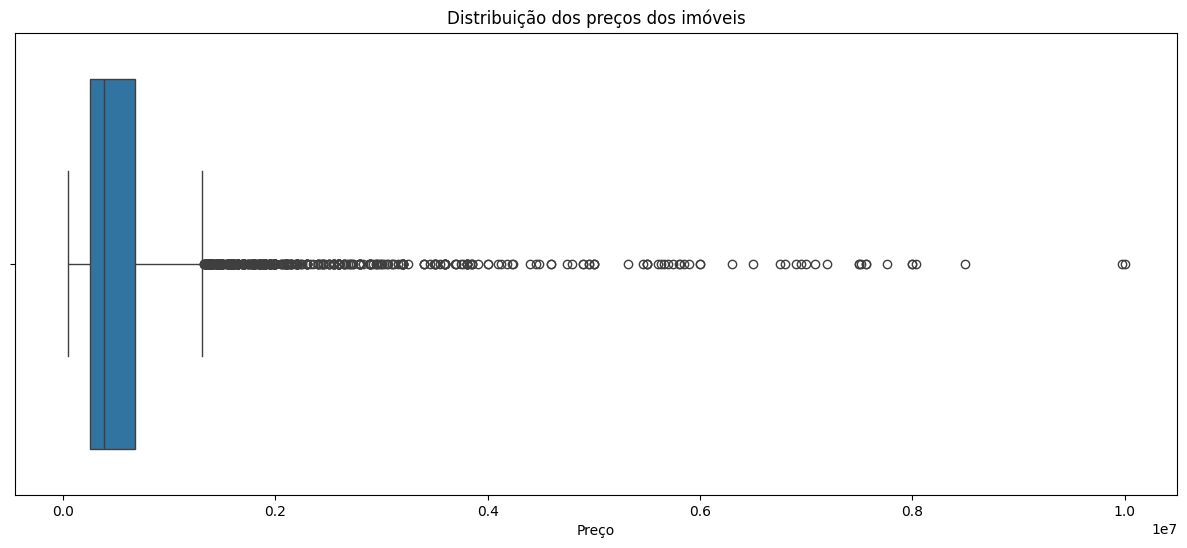

In [235]:
plt.figure(figsize=(15,6))
sns.boxplot(df['Price'], orient='h')
plt.title('Distribuição dos preços dos imóveis')
plt.xlabel('Preço')
plt.show()

Existem muitos valores outliers. É necessário tratá-los para não prejudicar o treinamento da rede.

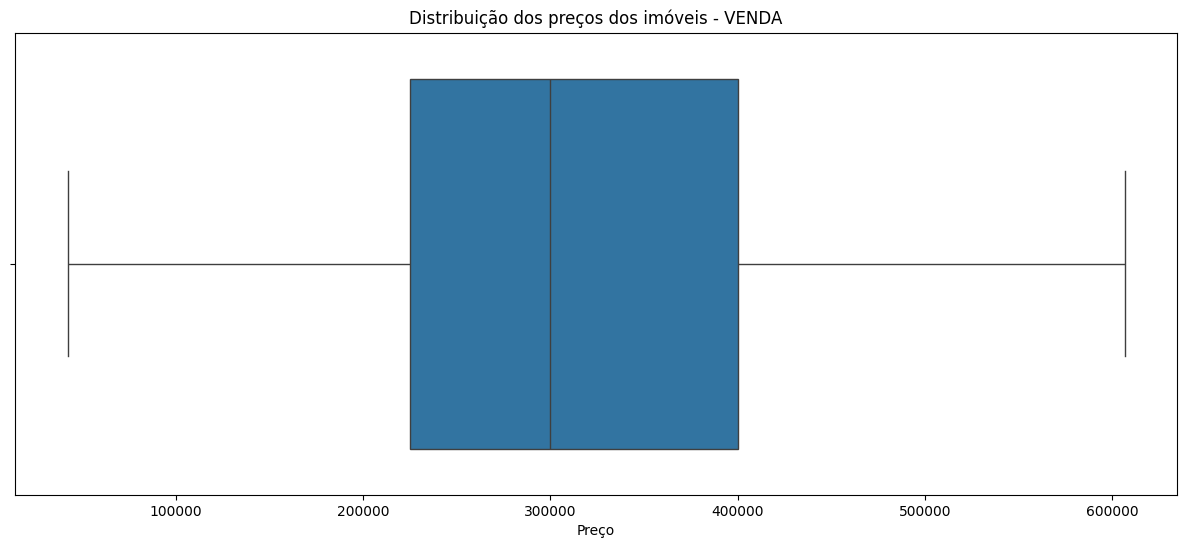

In [236]:
# Filtrar os dados removendo os outliers -> valores que estão abaixo da média
# df = df[(df["Price"] >= limite_inferior) & (df["Price"] <= limite_superior)]
df = df.loc[df['Price'] <= media_dos_imoveis]

plt.figure(figsize=(15,6))
sns.boxplot(df['Price'], orient='h')
plt.title('Distribuição dos preços dos imóveis - VENDA')
plt.xlabel('Preço')
plt.show()


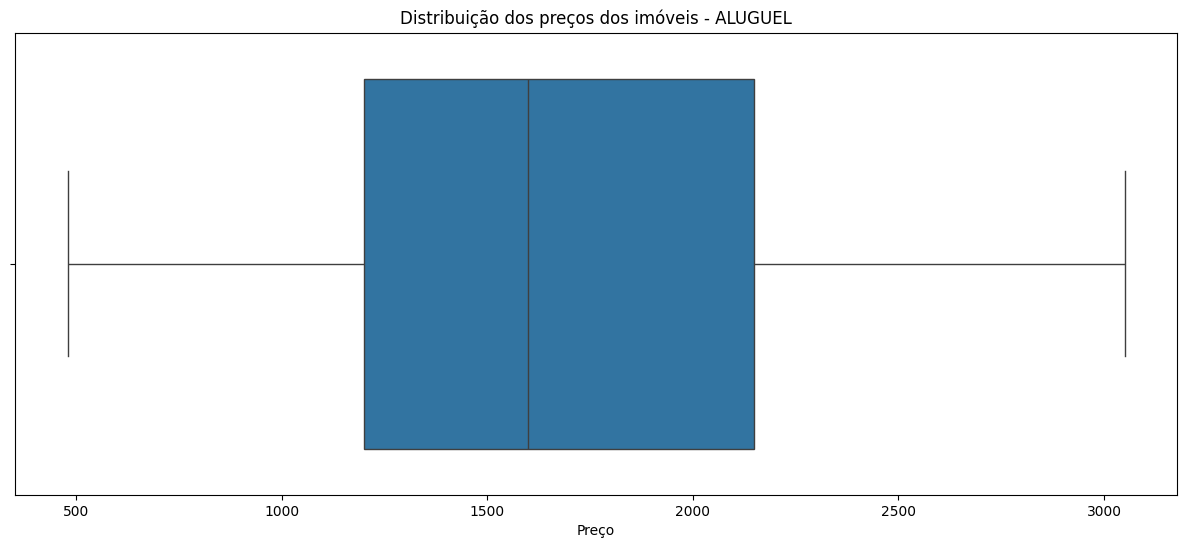

In [237]:
df_rent = df_rent.loc[df_rent['Price'] <= media_dos_imoveis_rent]

plt.figure(figsize=(15,6))
sns.boxplot(df_rent['Price'], orient='h')
plt.title('Distribuição dos preços dos imóveis - ALUGUEL')
plt.xlabel('Preço')
plt.show()

<Figure size 1500x600 with 0 Axes>

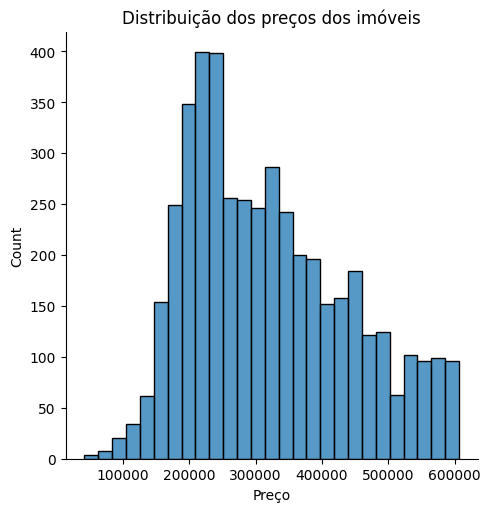

In [238]:
plt.figure(figsize=(15,6))
sns.displot(df['Price'])
plt.title('Distribuição dos preços dos imóveis')
plt.xlabel('Preço')
plt.show()

<Figure size 1500x600 with 0 Axes>

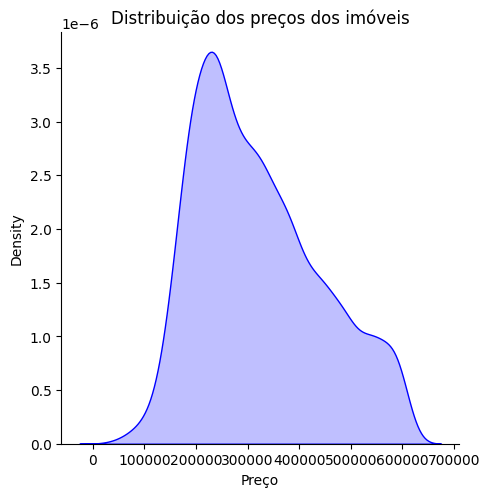

In [239]:
plt.figure(figsize=(15,6))
sns.displot(df['Price'], kind='kde', color='blue', fill=True)
plt.title('Distribuição dos preços dos imóveis')
plt.xlabel('Preço')
plt.show()

#### Analisar a distribuição dos preços pelos distritos na cidade de São Paulo

In [240]:
df['District'].value_counts()

District
Brás/São Paulo               126
Jaçanã/São Paulo             116
Bom Retiro/São Paulo         110
Casa Verde/São Paulo         100
Liberdade/São Paulo           97
                            ... 
Vila Leopoldina/São Paulo      5
Jardim Paulista/São Paulo      5
Itaim Bibi/São Paulo           4
Vila Madalena/São Paulo        4
Iguatemi/São Paulo             1
Name: count, Length: 96, dtype: int64

### Analisar correlação entre as variáveis
Antes de treinar nosso modelo de previsão de preços de imóveis, é essencial entender como as variáveis do nosso conjunto de dados se relacionam entre si, especialmente em relação a variável target (Price).

A correlação nos ajuda a identificar:

- Quais variáveis têm maior impacto no preço do imóvel (correlação forte positiva ou negativa).
- Quais variáveis podem ser redundantes (altamente correlacionadas entre si, podendo causar multicolinearidade).
- Quais variáveis podem ter pouca ou nenhuma influência direta no preço (correlação próxima de 0).

In [241]:
df.loc[:, ~df.columns.isin(list(df.select_dtypes(include=['object']).columns))].corr()['Price'].sort_values(ascending=False)

Price            1.000000
Size             0.569744
Condo            0.480053
Swimming Pool    0.348842
Parking          0.337052
Toilets          0.247019
Rooms            0.242559
Suites           0.209784
Furnished        0.131018
Elevator         0.117870
New             -0.069716
Latitude        -0.072803
Longitude       -0.074489
Name: Price, dtype: float64

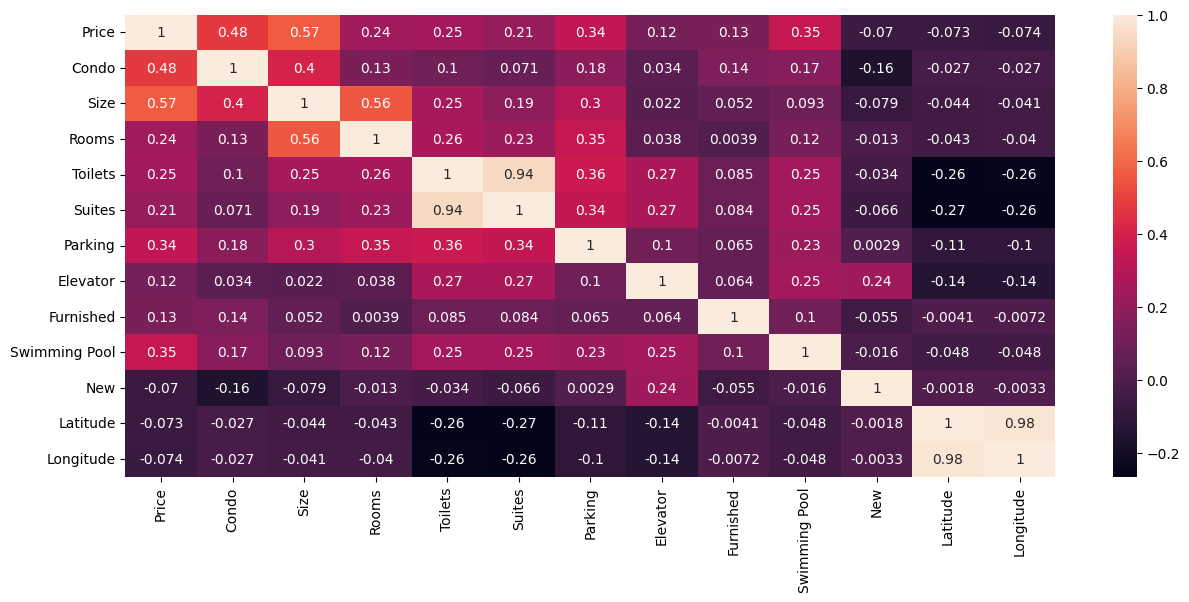

In [242]:
plt.figure(figsize=(15,6))
sns.heatmap(df.loc[:, ~df.columns.isin(list(df.select_dtypes(include=['object']).columns))].corr(), annot=True)
plt.show()

Temos boas variáveis correlacionando com a target.

## Tratamento dos dados

In [243]:
df.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
4928,530000,335,70,2,2,1,1,0,0,0,0,Vila Madalena/São Paulo,sale,apartment,-23.544128,-46.694184
4930,522900,700,83,3,2,1,2,1,0,1,0,Mooca/São Paulo,sale,apartment,-23.560846,-46.604266
4931,420000,0,71,3,2,1,2,1,0,1,0,Mooca/São Paulo,sale,apartment,-23.563045,-46.594365
4932,369000,295,63,2,2,1,1,1,0,1,0,Mooca/São Paulo,sale,apartment,-23.552691,-46.623627
4934,360000,543,50,2,2,1,1,0,0,1,0,Mooca/São Paulo,sale,apartment,-23.548100,-46.609283


In [244]:
df = df.drop(['Property Type', 'Latitude', 'Longitude', 'Furnished',  'Elevator', 'New'], axis=1)
df_rent = df_rent.drop(['Property Type', 'Latitude', 'Longitude', 'Furnished',  'Elevator', 'New'], axis=1)

## Preparação de dados para modelos de ML

#### Merge dos dois datasets

In [245]:
df_rent.shape, df.shape

((5297, 10), (4551, 10))

In [246]:
df = pd.concat([df_rent, df], ignore_index=True)
df['Negotiation Type'] = df['Negotiation Type'].map({'sale': 0, 'rent': 1})

encoder = LabelEncoder()
df['District'] = encoder.fit_transform(df['District'])
df.shape

(9848, 10)

In [247]:
pt = PowerTransformer(method='yeo-johnson')
df['Price'] = np.log1p(df['Price'])

In [248]:
X = df.drop('Price', axis=1)
X.head()

,Condo,Size,Rooms,Toilets,Suites,Parking,Swimming Pool,District,Negotiation Type
0,220,47,2,2,1,1,0,3,1
1,148,45,2,2,1,1,0,3,1
2,100,48,2,2,1,1,0,3,1
3,200,48,2,2,1,1,0,3,1
4,410,55,2,2,1,1,0,3,1


In [249]:
y = df['Price'].values.reshape(-1, 1)
y

array([[ 6.83625928],
       [ 6.90875478],
       [ 6.90875478],
       ...,
       [13.15192412],
       [12.75130259],
       [11.99527754]], shape=(9848, 1))

#### Pré-processador para standard scaler variáveis numéricas e codificar as variáveis categóricas

In [250]:
y = pt.fit_transform(y)
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), X.columns),
])
X_processed = preprocessor.fit_transform(X)

## Treinamento de modelos

In [251]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=42)

In [252]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [253]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

### Definir o modelo da rede neural para previsão dos preços dos imóveis

In [254]:
class HousePriceNN(nn.Module):
    def __init__(self, input_size):
        super(HousePriceNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.05),

            nn.Linear(128, 96),
            nn.ReLU(),
            nn.BatchNorm1d(96),
            nn.Dropout(0.05),

            nn.Linear(96, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            # nn.Dropout(0.1),

            nn.Linear(64, 48),
            nn.ReLU(),

            nn.Linear(48, 32),
            nn.ReLU(),

            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.model(x)

#### Inicializar o modelo, definir a loss function e o optimizer

In [255]:
input_dim = X_train.shape[1]
model = HousePriceNN(input_dim)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

#### Treinamento

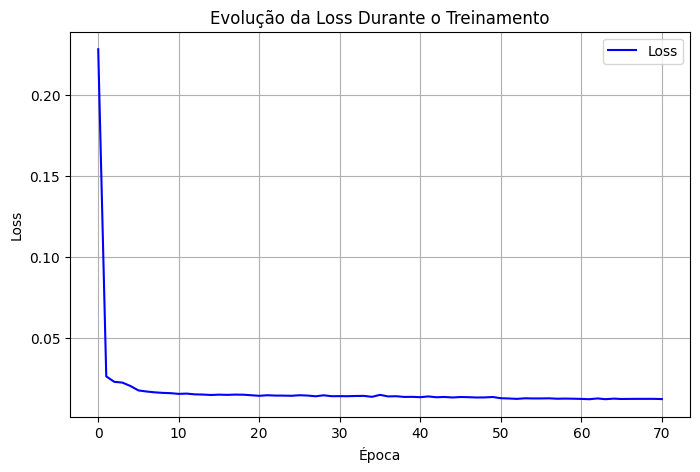

Early stopping ativado!
Treinamento finalizado


In [256]:
from IPython.display import clear_output

losses = []
epochs = 500
patience = 10
best_loss = float("inf")
counter = 0

for epoch in range(epochs):
	model.train()
	running_loss = 0.0

	for batch in train_loader:
		X_batch, y_batch = batch
		optimizer.zero_grad()
		outputs = model(X_batch)
		loss = criterion(outputs, y_batch)
		loss.backward()
		optimizer.step()
		running_loss += loss.item()

	scheduler.step()

	epoch_loss = running_loss / len(train_loader)
	losses.append(epoch_loss)

	# Early stopping
	if epoch_loss < best_loss:
		best_loss = epoch_loss
		counter = 0
	else:
		counter += 1
		if counter >= patience:
			print("Early stopping ativado!")
			break

	# Exibir logs a cada 20 épocas
	if epoch % 20 == 0:
		print(f"Época [{epoch}/{epochs}], Loss: {epoch_loss:.4f}")
  
	# Atualizar gráfico a cada época
	clear_output(wait=True)
	plt.figure(figsize=(8, 5))
	plt.plot(losses, label="Loss", color="blue")
	plt.xlabel("Época")
	plt.ylabel("Loss")
	plt.title("Evolução da Loss Durante o Treinamento")
	plt.legend()
	plt.grid(True)
	plt.show()

print("Treinamento finalizado")


In [257]:
# Avaliação
model.eval()
y_pred = model(X_test_tensor).detach().numpy()
y_true = y_test_tensor.numpy()

In [258]:
# Inverter transformação
y_pred = np.expm1(pt.inverse_transform(y_pred))
y_true = np.expm1(pt.inverse_transform(y_true))

In [259]:
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

In [260]:
print(f'R²: {r2:.4f}')
print(f'MAE: R$ {mae:.2f}')
print(f'RMSE: R$ {rmse:.2f}')

R²: 0.9198
MAE: R$ 25261.92
RMSE: R$ 50824.58


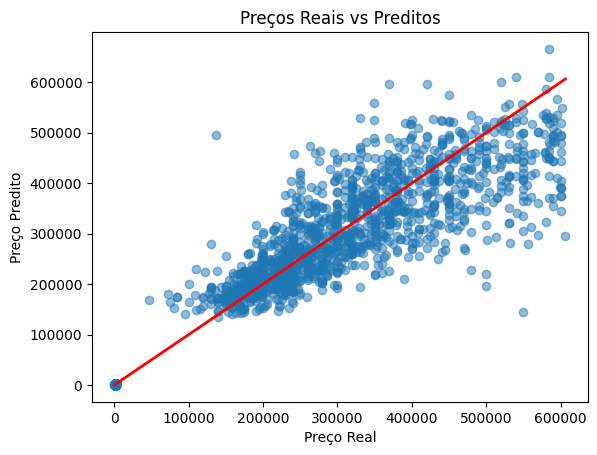

In [261]:
# plotar as previsões versus valores reais
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', lw=2)
plt.xlabel('Preço Real')
plt.ylabel('Preço Predito')
plt.title('Preços Reais vs Preditos')
plt.show()
